### SP025 Integration analysis Breast Cancer TME 

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
import loompy as lp
import rpy2.rinterface_lib.callbacks
import logging
import scrublet as scr
from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.4 scipy==1.4.1 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.2


In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.4 scipy==1.4.1 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.2


In [4]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths("/home/spuccio/miniconda3/envs/scrnseq/lib/R/library")

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)
library(clustree)
library(SingleCellExperiment)
library(CHETAH)
library(SingleR)
library(cowplot)
library(Matrix)

### Load Dataset CRC 

In [5]:
path_bc="/home/spuccio/isilon/spuccio/SP025_NaClTcell/PangenomeBlueprint/BC_counts/"
adata_bc = sc.read("".join([path_bc,"matrix.mtx"]), cache=True)
adata_bc = adata_bc.transpose()
adata_bc.X = adata_bc.X.toarray()
barcodes = pd.read_csv("".join([path_bc,"barcodes.tsv"]), header=None, sep='\t')
genes = pd.read_csv("".join([path_bc,"genes.tsv"]), header=None, sep='\t')
#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata_bc.obs = barcodes
genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata_bc.var = genes
Metadata_bc = pd.read_csv("/home/spuccio/isilon/spuccio/SP025_NaClTcell/PangenomeBlueprint/BC_metadata.csv",header=0,low_memory=False)
adata_bc.obs['CellId'] = Metadata_bc["Cell"].to_list()
adata_bc.obs['CellFromTumor'] = Metadata_bc["CellFromTumor"].to_list()
adata_bc.obs['PatientNumber'] = Metadata_bc["PatientNumber"].to_list()
adata_bc.obs['TumorType'] = Metadata_bc["TumorType"].to_list()
adata_bc.obs['TumorSite'] = Metadata_bc["TumorSite"].to_list()
adata_bc.obs['CellType'] = Metadata_bc["CellType"].to_list()

... reading from cache file cache/home-spuccio-isilon-spuccio-SP025_NaClTcell-PangenomeBlueprint-BC_counts-matrix.h5ad


In [6]:
adata_bc_Tcell = adata_bc[adata_bc.obs['CellType']  == "T_cell",:]
adata_bc_Cancer = adata_bc[adata_bc.obs['CellType']  == "Cancer",:]

/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


### Filter low expressed genes

In [7]:
sc.pp.filter_genes(adata_bc_Tcell, min_cells=10)
sc.pp.filter_cells(adata_bc_Tcell, min_genes=200)

filtered out 17055 genes that are detected in less than 10 cells


Trying to set attribute `.var` of view, copying.


In [8]:
adata_bc_Tcell.raw = adata_bc_Tcell

### QC metrics

In [9]:
sc.pp.calculate_qc_metrics(adata_bc_Tcell, inplace=True)

In [10]:
adata_bc_Tcell.var['mt'] = adata_bc_Tcell.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_bc_Tcell, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [11]:
adata_bc_Tcell.var['rb'] = adata_bc_Tcell.var_names.str.startswith('RP')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_bc_Tcell, qc_vars=['rb'], percent_top=None, log1p=False, inplace=True)

In [12]:
#sc.pl.violin(adata_bc_Tcell, ['pct_counts_mt'],
#             jitter=0.4, multi_panel=False)

normalizing counts per cell
    finished (0:00:00)


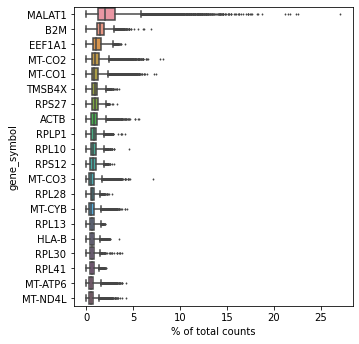

In [13]:
sc.pl.highest_expr_genes(adata_bc_Tcell, n_top=20)

In [14]:
print("Cell x Genes before filtering")
print(adata_bc_Tcell.n_obs, adata_bc_Tcell.n_vars)

Cell x Genes before filtering
14395 16639


In [15]:
#sc.pl.violin(adata_bc_Tcell, ['pct_counts_rb'],jitter=0.4)

In [16]:
adata_bc_Tcell = adata_bc_Tcell[adata_bc_Tcell.obs.pct_counts_rb < 45, :]
print("Cell x Genes after filtering cell with high ribosomial")
print(adata_bc_Tcell.n_obs, adata_bc_Tcell.n_vars)

/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Cell x Genes after filtering cell with high ribosomial
14305 16639


In [17]:
#sc.pl.violin(adata_bc_Tcell, ['pct_counts_mt'],jitter=0.4)

In [18]:
adata_bc_Tcell = adata_bc_Tcell[adata_bc_Tcell.obs.pct_counts_mt < 10, :]
print("Cell x Genes after filtering cell with high mithocondrial")
print(adata_bc_Tcell.n_obs, adata_bc_Tcell.n_vars)

/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Cell x Genes after filtering cell with high mithocondrial
11981 16639


In [19]:
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["external_gene_name", "start_position", "end_position", "chromosome_name","gene_biotype"],).set_index("external_gene_name")

In [20]:
annot['gene_biotype'].unique()

array(['Mt_tRNA', 'Mt_rRNA', 'protein_coding', 'processed_pseudogene',
       'lncRNA', 'snRNA', 'unprocessed_pseudogene', 'misc_RNA',
       'transcribed_unprocessed_pseudogene',
       'transcribed_processed_pseudogene', 'TEC', 'rRNA',
       'IG_V_pseudogene', 'rRNA_pseudogene', 'miRNA',
       'transcribed_unitary_pseudogene', 'unitary_pseudogene', 'snoRNA',
       'scaRNA', 'polymorphic_pseudogene', 'pseudogene', 'ribozyme',
       'sRNA', 'TR_V_gene', 'TR_V_pseudogene', 'TR_D_gene', 'TR_J_gene',
       'TR_C_gene', 'TR_J_pseudogene', 'IG_C_gene', 'IG_C_pseudogene',
       'IG_J_gene', 'IG_J_pseudogene', 'IG_D_gene', 'IG_V_gene',
       'IG_pseudogene', 'translated_processed_pseudogene', 'scRNA',
       'vault_RNA', 'translated_unprocessed_pseudogene'], dtype=object)

In [21]:
#len(pd.merge(pd.DataFrame(adata_bc_Tcell.var_names),annot,left_on="gene_symbol",right_on="external_gene_name",how="left"))

In [22]:
annot = pd.merge(pd.DataFrame(adata_bc_Tcell.var_names),annot,left_on="gene_symbol",right_on="external_gene_name",how="left")

In [23]:
annot= annot.drop_duplicates(['gene_symbol'])

In [24]:
annot = annot.fillna("Not_available")

In [25]:
adata_bc_Tcell.var['gene_biotype'] = annot.set_index("gene_symbol")['gene_biotype']
protein_coding = annot['gene_symbol'].loc[annot['gene_biotype']=="protein_coding"].reset_index()
del protein_coding['index']
protein_gene_indicator = np.in1d(adata_bc_Tcell.var_names, protein_coding)
adata_bc_Tcell = adata_bc_Tcell[:, protein_gene_indicator]

Trying to set attribute `.var` of view, copying.


In [26]:
mito_gene_names = sc.queries.mitochondrial_genes("hsapiens")

In [27]:
mito_gene_indicator = np.in1d(adata_bc_Tcell.var_names, mito_gene_names)

In [28]:
adata_bc_Tcell = adata_bc_Tcell[:, ~mito_gene_indicator]

In [29]:
adata_bc_Tcell

View of AnnData object with n_obs × n_vars = 11981 × 13291
    obs: 'CellId', 'CellFromTumor', 'PatientNumber', 'TumorType', 'TumorSite', 'CellType', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb'
    var: 'gene_id', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'rb', 'gene_biotype'

In [30]:
print(adata_bc_Tcell.n_obs, adata_bc_Tcell.n_vars)
malat1 = adata_bc_Tcell.var_names.str.startswith('MALAT1')
#protein_genes= adata_bc_Tcell.var.gene_biotype.str.startswith('protein_coding')
ribo_genes = adata_bc_Tcell.var_names.str.startswith(("RPS","RPL"))
remove = np.add(ribo_genes, malat1)
keep = np.invert(remove)

adata_bc_Tcell = adata_bc_Tcell[:,keep]

print(adata_bc_Tcell.n_obs, adata_bc_Tcell.n_vars)

11981 13291
11981 13197


In [31]:
print(adata_bc_Tcell.n_obs, adata_bc_Tcell.n_vars)

11981 13197


In [32]:
adata_bc_Tcell.raw = adata_bc_Tcell

In [33]:
sc.pp.normalize_total(adata_bc_Tcell, target_sum=1e4)
sc.pp.log1p(adata_bc_Tcell)

normalizing counts per cell
    finished (0:00:00)


In [34]:
sc.pp.highly_variable_genes(adata_bc_Tcell, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [35]:
adata_bc_Tcell.raw = adata_bc_Tcell

In [36]:
#pd.DataFrame(adata_bc_Tcell.var.highly_variable).loc[pd.DataFrame(adata_bc_Tcell.var.highly_variable)['highly_variable'] == True].head(50)

normalizing counts per cell
    finished (0:00:00)


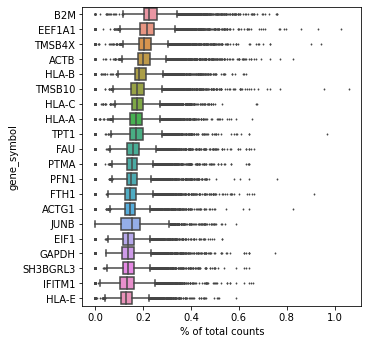

In [37]:
sc.pl.highest_expr_genes(adata_bc_Tcell, n_top=20)

### Principal component analysis

In [38]:
#adata_bc_Tcell = adata_bc_Tcell[:, adata_bc_Tcell.var.highly_variable]

In [39]:
#sc.pp.scale(adata_bc_Tcell, max_value=10)

In [40]:
sc.tl.pca(adata_bc_Tcell, svd_solver='arpack',use_highly_variable=True)

computing PCA
    on highly variable genes
    with n_comps=50


/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    finished (0:00:01)


/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'TumorType' as categorical
... storing 'TumorSite' as categorical
... storing 'CellType' as categorical
... storing 'gene_biotype' as categorical


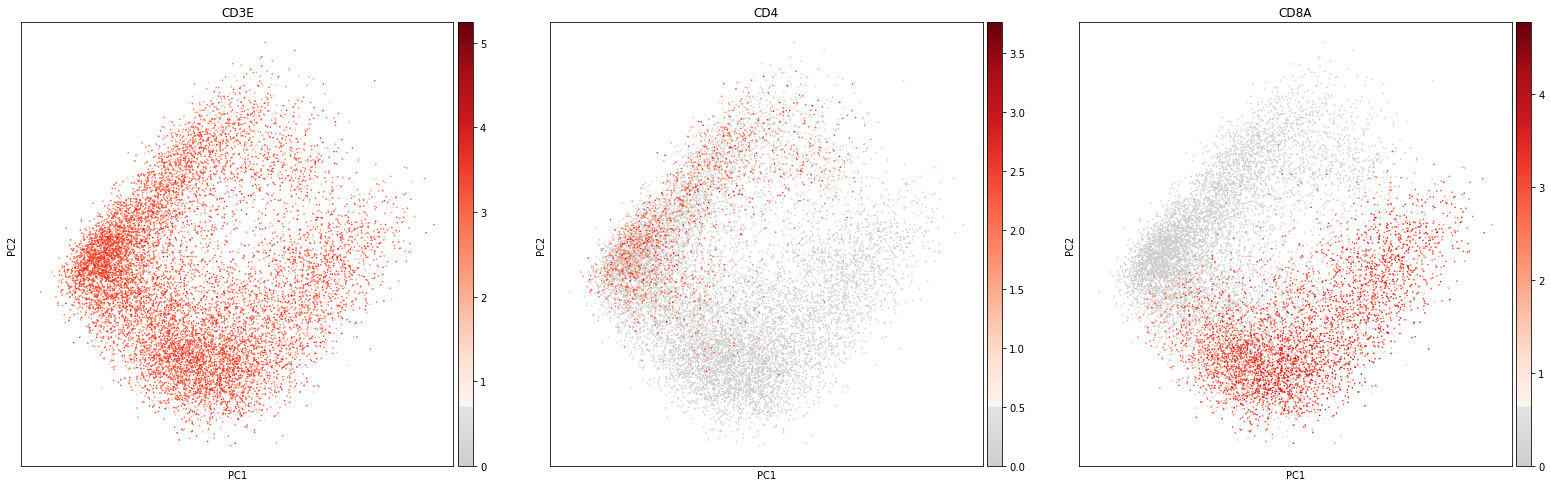

In [41]:

colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
sc.pl.pca(adata_bc_Tcell, color=['CD3E','CD4','CD8A'],color_map=mymap)

### Computing the neighborhood graph

In [42]:
sc.pp.neighbors(adata_bc_Tcell, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)


### Embedding the neighborhood graph

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


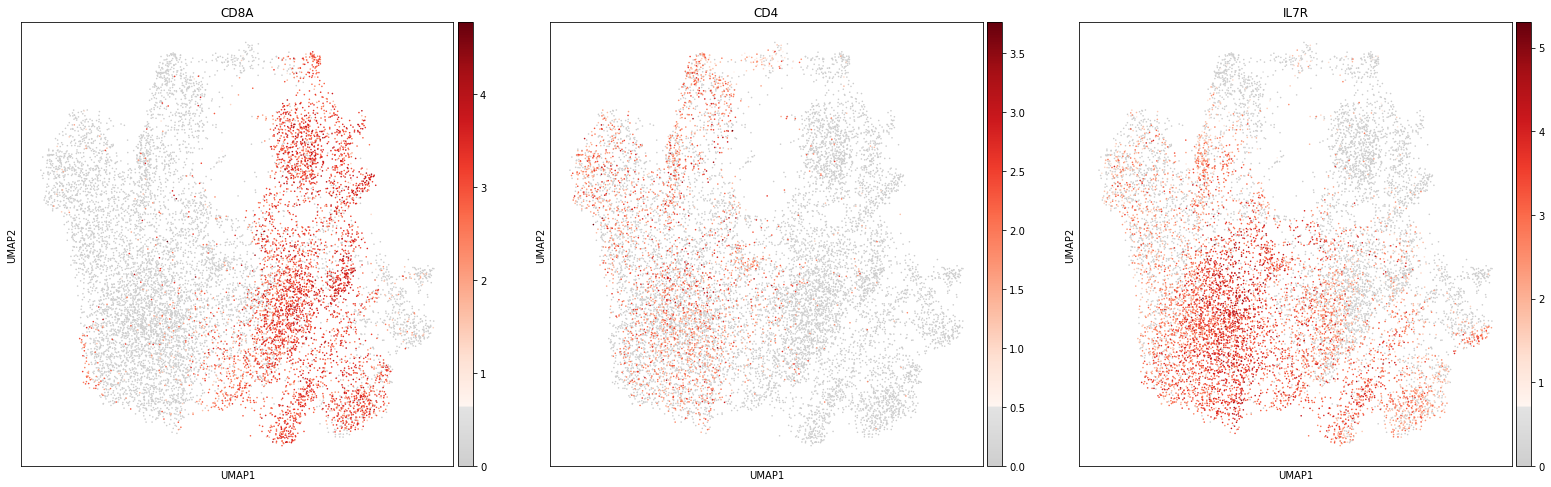

In [43]:
sc.tl.umap(adata_bc_Tcell)
sc.pl.umap(adata_bc_Tcell, color=['CD8A', 'CD4', 'IL7R'],color_map=mymap,use_raw=True); plt.show()

### Clustering the neighborhood graph

In [44]:
sc.tl.leiden(adata_bc_Tcell, resolution=0.7, key_added='leiden_r7_clusters',random_state=49)
sc.tl.leiden(adata_bc_Tcell, resolution=0.5, key_added='leiden_r5_clusters',random_state=49)
sc.tl.leiden(adata_bc_Tcell, resolution=0.4, key_added='leiden_r4_clusters',random_state=49)
sc.tl.leiden(adata_bc_Tcell, resolution=0.6, key_added='leiden_r6_clusters',random_state=49)
sc.tl.leiden(adata_bc_Tcell, resolution=0.8, key_added='leiden_r8_clusters',random_state=49)

running Leiden clustering
    finished: found 12 clusters and added
    'leiden_r7_clusters', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_r5_clusters', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_r4_clusters', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden_r6_clusters', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden_r8_clusters', the cluster labels (adata.obs, categorical) (0:00:01)


### clustree: Visualise Clusterings at Different Resolutions.

In [45]:
data_clus = adata_bc_Tcell.obs[['leiden_r7_clusters','leiden_r5_clusters','leiden_r4_clusters','leiden_r6_clusters','leiden_r8_clusters']]

In [46]:
data_clus.to_csv("/mnt/lugli/spuccio/SP028_Autoimmunity/h5_files/temp.csv",index=True,header=True)
data_clus2 = pd.read_csv("/mnt/lugli/spuccio/SP028_Autoimmunity/h5_files/temp.csv",index_col=0,header=0)

In [47]:
# these are the defaults we want to set:
default_units = 'in' # inch, to make it more easily comparable to matpplotlib
default_res = 100 # dpi, same as default in matplotlib
default_width = 10
default_height = 9
# try monkey-patching a function in rpy2, so we effectively get these
# default settings for the width, height, and units arguments of the %R magic command
import rpy2
old_setup_graphics = rpy2.ipython.rmagic.RMagics.setup_graphics

def new_setup_graphics(self, args):
    if getattr(args, 'units') is not None:
        if args.units != default_units: # a different units argument was passed, do not apply defaults
            return old_setup_graphics(self, args)
    args.units = default_units
    if getattr(args, 'res') is None:
        args.res = default_res
    if getattr(args, 'width') is None:
        args.width = default_width
    if getattr(args, 'height') is None:
        args.height = default_height        
    return old_setup_graphics(self, args)

rpy2.ipython.rmagic.RMagics.setup_graphics = new_setup_graphics

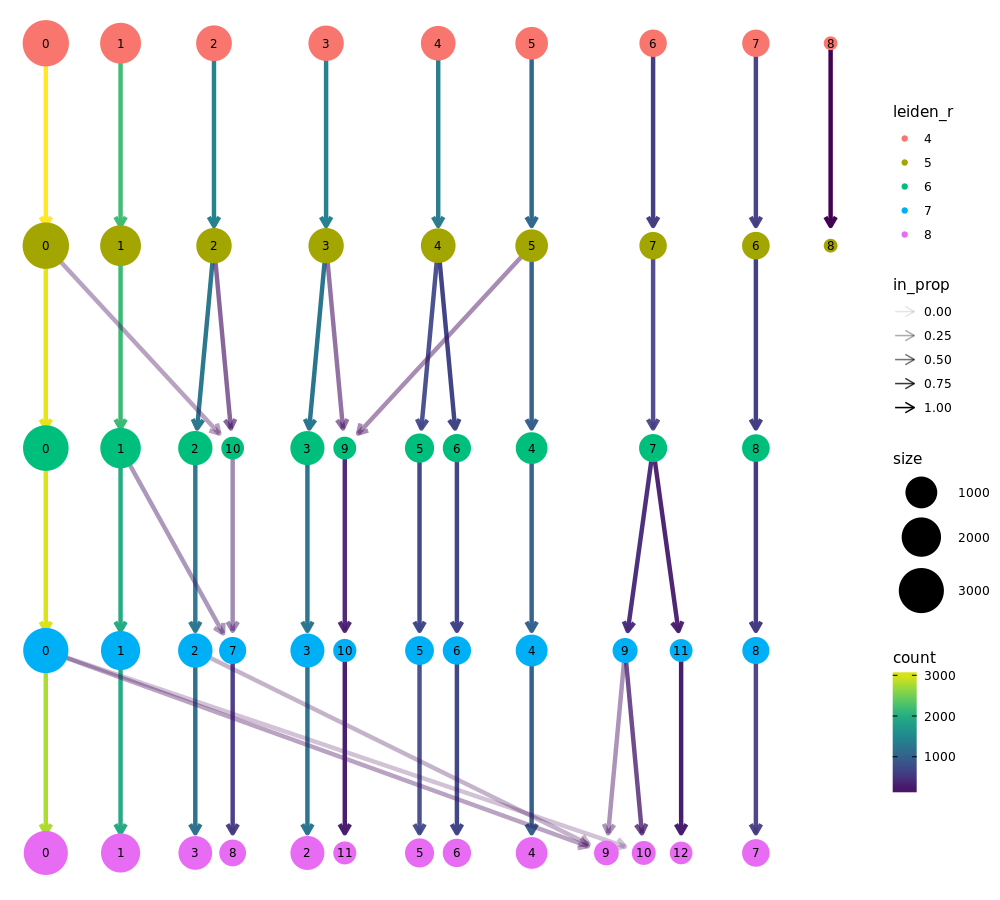

In [48]:
%%R -i data_clus2
library(clustree)

clustree(data_clus2,prefix="leiden_r",suffix = "_clusters")

## UMAP of Cluster 

In [49]:
sc.tl.paga(adata_bc_Tcell,groups='leiden_r5_clusters')
sc.pl.paga(adata_bc_Tcell, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata_bc_Tcell, init_pos='paga')

running PAGA


/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


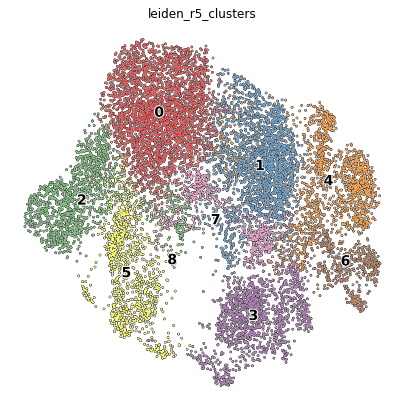

In [50]:
rcParams['figure.figsize'] = 7, 7
sc.pl.umap(adata_bc_Tcell, color='leiden_r5_clusters', add_outline=True,legend_loc='on data', 
           legend_fontsize=14, legend_fontoutline=2,frameon=False,
           title='leiden_r5_clusters', palette='Set1')

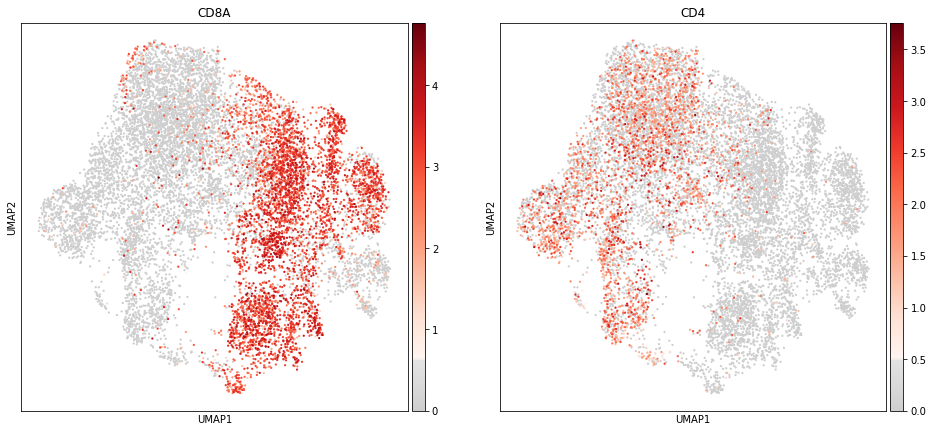

In [51]:
sc.pl.umap(adata_bc_Tcell, color=['CD8A','CD4'],color_map=mymap,legend_loc='on data',s=20 )

### Number of cells X cluster 

In [52]:
adata_bc_Tcell.obs['leiden_r5_clusters'].value_counts()

0    3254
1    2237
2    1436
3    1425
4    1341
5    1089
6     600
7     586
8      13
Name: leiden_r5_clusters, dtype: int64

In [53]:
adata_bc_Tcell.obs['leiden_r5_clusters'].value_counts(normalize=True)*100

0    27.159669
1    18.671229
2    11.985644
3    11.893832
4    11.192722
5     9.089392
6     5.007929
7     4.891078
8     0.108505
Name: leiden_r5_clusters, dtype: float64

### Finding marker genes

In [54]:
#sc.tl.rank_genes_groups(adata_bc_Tcell, 'leiden_r5_clusters', method='wilcoxon')
#pd.DataFrame(adata_bc_Tcell.uns['rank_genes_groups']['names']).head(50)

### Violin plot of some T-associated genes

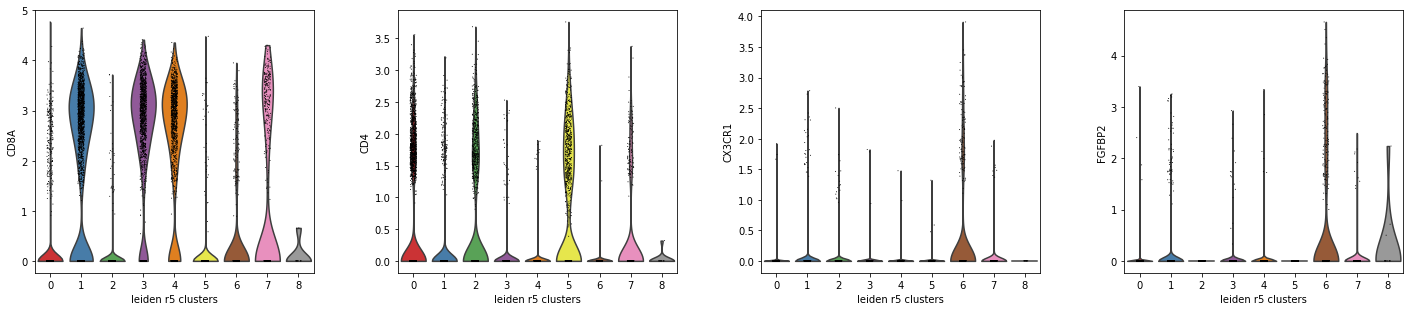

In [55]:
import warnings
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 5,5
sc.pl.violin(adata_bc_Tcell, ['CD8A', 'CD4','CX3CR1','FGFBP2'], groupby='leiden_r5_clusters')

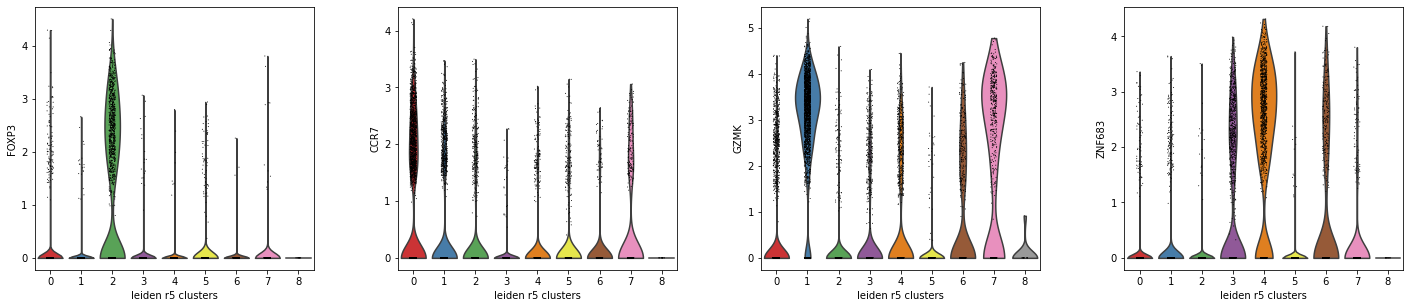

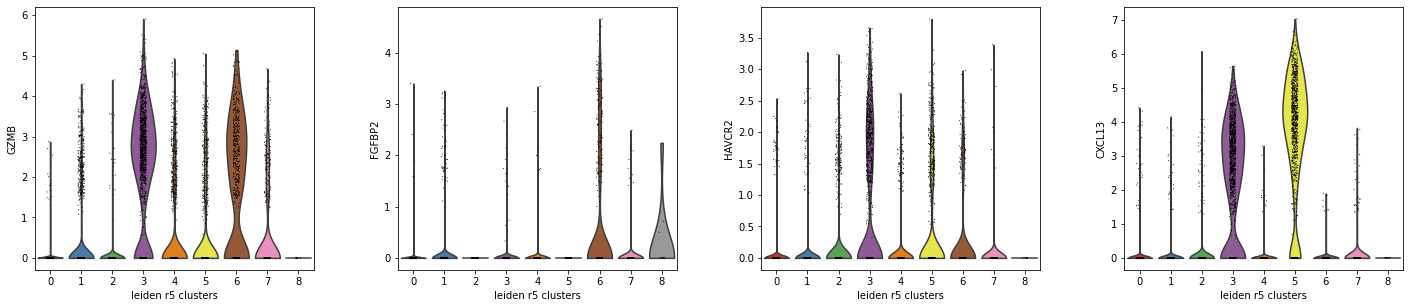

In [56]:
rcParams['figure.figsize'] = 5,5
sc.pl.violin(adata_bc_Tcell, ['FOXP3','CCR7','GZMK','ZNF683'], groupby='leiden_r5_clusters' )
sc.pl.violin(adata_bc_Tcell, ['GZMB','FGFBP2','HAVCR2','CXCL13'], groupby='leiden_r5_clusters' )

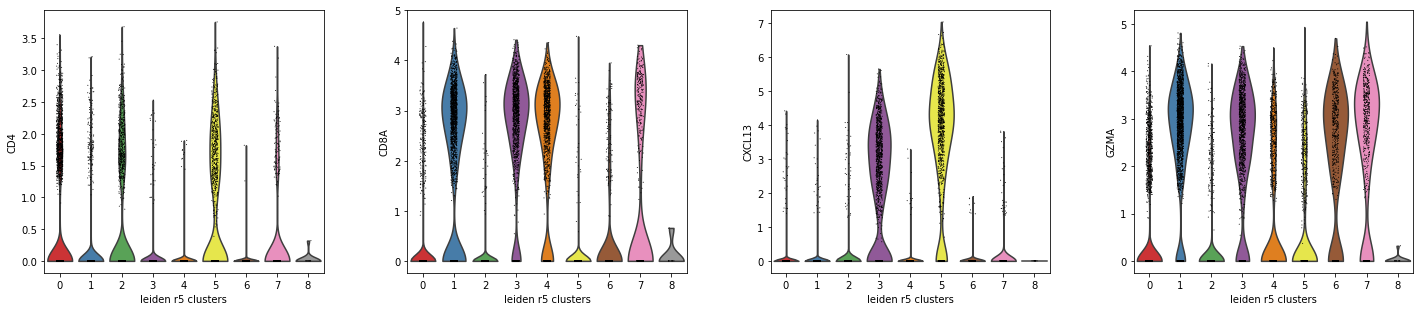

In [57]:
rcParams['figure.figsize'] = 5,5
sc.pl.violin(adata_bc_Tcell, ['CD4','CD8A','CXCL13','GZMA'], groupby='leiden_r5_clusters' )

### Rename cluster 

In [58]:
new_cluster_names = ['C0_CD4_CCR7','C1_CD8_GZMK','C2_CD4_FOXP3','C3_CD8_HAVCR2','C4_CD8_ZNF683','C5_CD4_CXCL13','C6_NK_FGFBP2','C7_CD8_GZMK','C8_CD4']
adata_bc_Tcell.rename_categories('leiden_r5_clusters', new_cluster_names)

In [59]:
adata_bc_Tcell = adata_bc_Tcell[adata_bc_Tcell.obs['leiden_r5_clusters'].isin(['C0_CD4_CCR7','C1_CD8_GZMK','C2_CD4_FOXP3','C3_CD8_HAVCR2','C4_CD8_ZNF683','C5_CD4_CXCL13','C6_NK_FGFBP2','C1_CD8_GZMK']),:]

### Marker genes

In [60]:
sc.tl.rank_genes_groups(adata_bc_Tcell, 'leiden_r5_clusters', method='wilcoxon')
pd.DataFrame(adata_bc_Tcell.uns['rank_genes_groups']['names']).head(20)

ranking genes


Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:14)


C0_CD4_CCR7 C1_CD8_GZMK C2_CD4_FOXP3 C3_CD8_HAVCR2 C4_CD8_ZNF683  \
0       EEF1A1        GZMK        FOXP3          GZMB        ZNF683   
1         TPT1        CST7         IL32          CCL5          CTSW   
2         IL7R        GZMA        CTLA4      HLA-DRB1          XCL1   
3       EEF1B2        CCL5      TNFRSF4          NKG7           CD7   
4          LTB        NKG7     TNFRSF1B          CD8A          CD8A   
5         NACA        CCL4         SAT1        CXCL13          HOPX   
6       PABPC1        CD8A          LTB          CCL4          MATK   
7         EEF2        CD74         BATF          LAG3          CD8B   
8         LDHB        GZMM         PIM2          CD8B         KLRD1   
9        SARAF       HLA-C       S100A4      HLA-DPA1         ITM2C   
10       FXYD5        CD8B       TBC1D4         GAPDH          CCL5   
11         FOS        TC2N       CARD16          PTMS          GNLY   
12         FAU       ITM2C        TIGIT       HLA-DRA          CTSA   
13       UBA52       HLA-B        IL2RA       ALOX5AP          CD63   
14        JUNB       HLA-A       TMSB10          MT2A          HCST   
15     ZFP36L2    HLA-DPB1     TNFRSF18      HLA-DRB5          NKG7   
16       PFDN5       EOMES         GBP5        IFITM3        STK17A   
17        CCR7        CMC1       ARID5B           ID2           VIM   
18       DUSP1       CXCR4         ICOS       PTPRCAP          AOAH   
19       EEF1D       KLRG1        ISG20          CD74     MTRNR2L12   

   C5_CD4_CXCL13 C6_NK_FGFBP2  
0         CXCL13         GNLY  
1          GAPDH       TYROBP  
2       TNFRSF18         NKG7  
3        TNFRSF4        KLRD1  
4          NR3C1         CTSW  
5          DUSP4       FCER1G  
6          PDCD1         HOPX  
7           SRGN         PRF1  
8            PKM         MATK  
9           RBPJ       IFITM2  
10          TYMP        KLRC1  
11          TPI1         XCL2  
12         FKBP5         GZMB  
13          CD82         CST7  
14         TIGIT          CD7  
15           CD2        IL2RB  
16         ITM2A         XCL1  
17           CD4       SH2D1B  
18          PFN1        KLRB1  
19         PGAM1        KLRF1

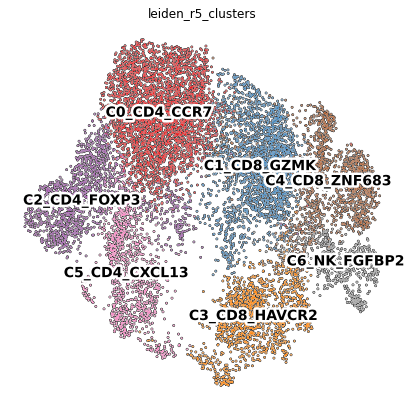

In [61]:
rcParams['figure.figsize'] = 7, 7
sc.pl.umap(adata_bc_Tcell, color='leiden_r5_clusters', add_outline=True,legend_loc='on data', 
           legend_fontsize=14, legend_fontoutline=5,frameon=False,
           title='leiden_r5_clusters', palette='Set1')

In [62]:
marker_genes_dict = {'T-cell': ['CD8A','CD4'],
                     'C0_CD4_CCR7': ['CCR7'],
                     'C1_CD8_GZMK': ['GZMK'],
                     'C2_CD4_FOXP3': ['FOXP3'],
                     'C3_CD8_HAVCR2': ['HAVCR2'],
                     'C4_CD8_ZNF683': ['ZNF683'],
                     'C5_CD4_CXCL13': ['CXCL13'],
                     'C6_NK_FGFBP2' : ['FGFBP2','NKG7'],
                     'C7_CD8_GZMK' : ['GZMK']}

### Marker genes x cluster

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns["dendrogram_['leiden_r5_clusters']"]`
categories: C0_CD4_CCR7, C1_CD8_GZMK, C2_CD4_FOXP3, etc.
var_group_labels: T-cell, C0_CD4_CCR7, C1_CD8_GZMK, etc.


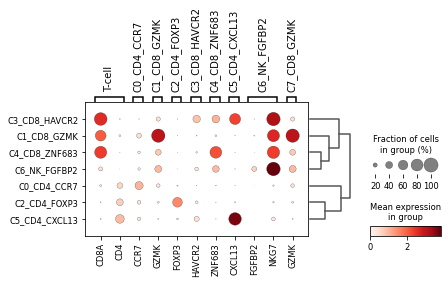

In [63]:
rcParams['figure.figsize'] = 10,10
sc.pl.dotplot(adata_bc_Tcell, marker_genes_dict, 'leiden_r5_clusters', dendrogram=True)

### Remove NK cluster

In [64]:
adata_bc_Tcell = adata_bc_Tcell[adata_bc_Tcell.obs['leiden_r5_clusters'].isin(['C0_CD4_CCR7','C1_CD8_GZMK','C2_CD4_FOXP3','C3_CD8_HAVCR2','C4_CD8_ZNF683','C5_CD4_CXCL13','C1_CD8_GZMK']),:]

In [65]:
sc.tl.rank_genes_groups(adata_bc_Tcell, 'leiden_r5_clusters', method='wilcoxon')
pd.DataFrame(adata_bc_Tcell.uns['rank_genes_groups']['names']).head(20)

ranking genes


Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:12)


C0_CD4_CCR7 C1_CD8_GZMK C2_CD4_FOXP3 C3_CD8_HAVCR2 C4_CD8_ZNF683  \
0       EEF1A1        GZMK        FOXP3          GZMB        ZNF683   
1         TPT1        CST7         IL32          NKG7          CTSW   
2         IL7R        GZMA        CTLA4          CCL5          XCL1   
3       EEF1B2        NKG7      TNFRSF4      HLA-DRB1           CD7   
4          LTB        CCL5     TNFRSF1B          CCL4          HOPX   
5         NACA        CCL4         SAT1          CD8A          CD8A   
6       PABPC1        GZMM         BATF        CXCL13          MATK   
7         EEF2        CD8A         PIM2          LAG3         KLRD1   
8         LDHB        CD74          LTB          CD8B          GNLY   
9        SARAF       HLA-C       S100A4      HLA-DPA1         ITM2C   
10         FOS        CD8B       TBC1D4          PTMS          CCL5   
11       FXYD5       ITM2C       CARD16         GAPDH          CD8B   
12         FAU        TC2N        IL2RA       HLA-DRA          NKG7   
13       UBA52       HLA-B     TNFRSF18       ALOX5AP          CD63   
14        JUNB        CMC1        TIGIT        IFITM3          CTSA   
15     ZFP36L2       EOMES       TMSB10          MT2A          HCST   
16       DUSP1       SAMD3         GBP5           ID2        STK17A   
17       PFDN5       HLA-A       ARID5B      HLA-DRB5          AOAH   
18        CCR7    HLA-DPB1        ISG20          GZMA        IFITM2   
19       EEF1D       KLRG1         ICOS          CTSW         PTGDR   

   C5_CD4_CXCL13  
0         CXCL13  
1          GAPDH  
2       TNFRSF18  
3        TNFRSF4  
4          NR3C1  
5           SRGN  
6          DUSP4  
7          PDCD1  
8            PKM  
9           RBPJ  
10          TPI1  
11          TYMP  
12         FKBP5  
13          CD82  
14          PFN1  
15         TIGIT  
16           CD2  
17         ITM2A  
18         PGAM1  
19           CD4

### Cluster correlation

In [66]:
sc.tl.dendrogram(adata_bc_Tcell, 'leiden_r5_clusters')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns["dendrogram_['leiden_r5_clusters']"]`


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_r5_clusters']`


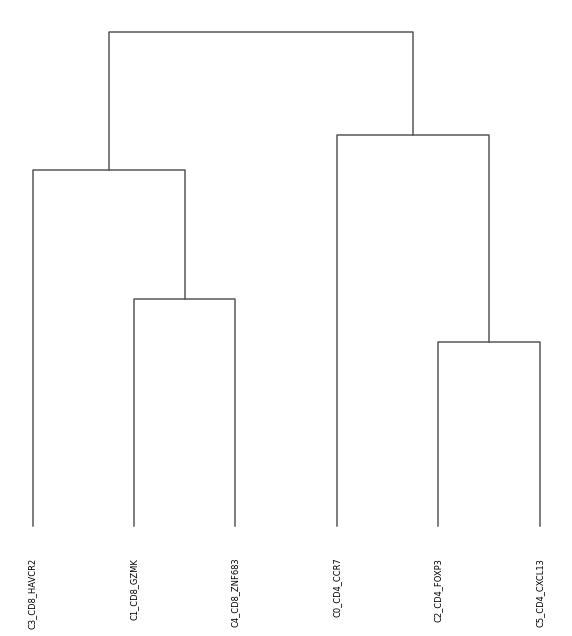

In [67]:
ax = sc.pl.dendrogram(adata_bc_Tcell, 'leiden_r5_clusters')

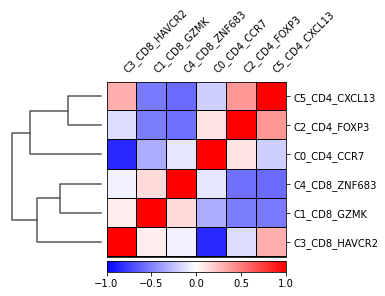

In [68]:
ax = sc.pl.correlation_matrix(adata_bc_Tcell, 'leiden_r5_clusters', figsize=(5,3.5))

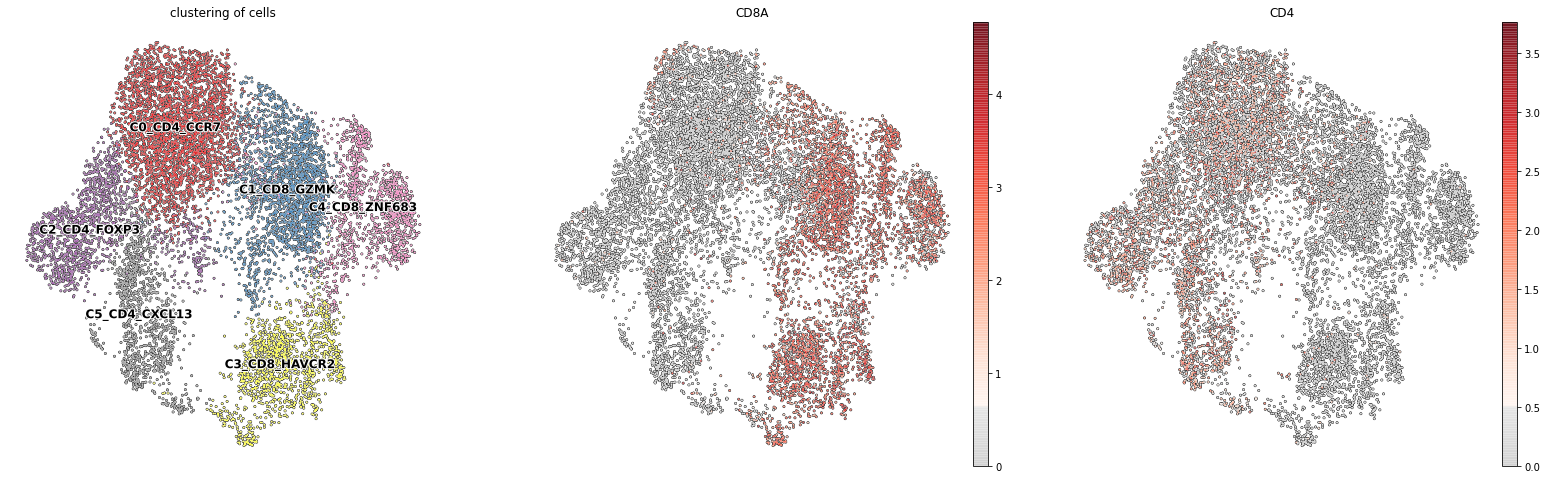

In [69]:
rcParams['figure.figsize'] = 8, 8
sc.pl.umap(adata_bc_Tcell, color=['leiden_r5_clusters','CD8A','CD4'],color_map=mymap, add_outline=True,legend_loc='on data', 
           legend_fontsize=12, legend_fontoutline=2,frameon=False,
           title='clustering of cells', palette='Set1')

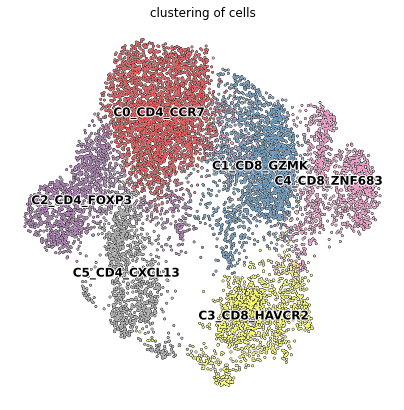

In [70]:
rcParams['figure.figsize'] = 7, 7
sc.pl.umap(adata_bc_Tcell, color=['leiden_r5_clusters'], add_outline=True,legend_loc='on data', 
           legend_fontsize=12, legend_fontoutline=2,frameon=False,
           title='clustering of cells', palette='Set1',color_map=mymap)

### Cluster information

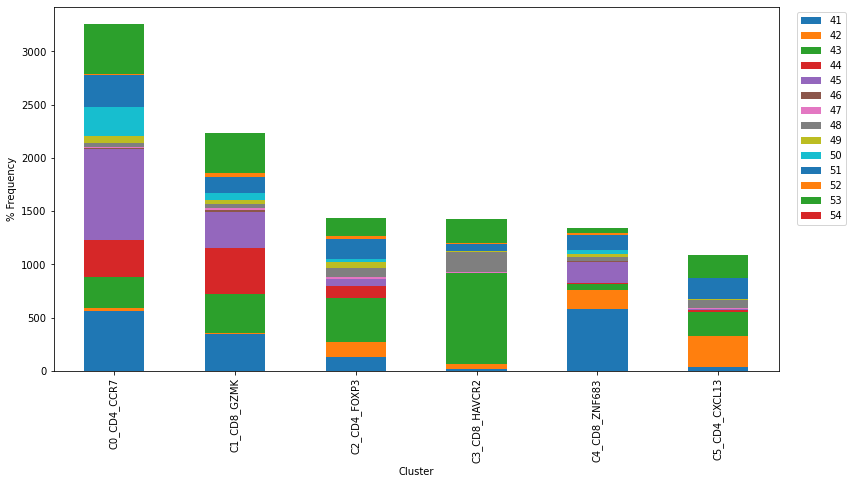

In [71]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata_bc_Tcell.obs.groupby("leiden_r5_clusters")["PatientNumber"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

### Export list and object

In [72]:
result = adata_bc_Tcell.uns['rank_genes_groups']

In [73]:
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:3]: result[key][group]
    for group in groups for key in ['names', 'pvals','logfoldchanges']}).to_csv("/home/spuccio/isilon/spuccio/SP025_NaClTcell/Analysis/BC_output/BC_DEGS.csv",header=True,index=False)

In [74]:
adata_bc_Tcell.write("/home/spuccio/isilon/spuccio/SP025_NaClTcell/Analysis/BC_output/adata_bc_Tcell.h5ad")

... storing 'gene_biotype' as categorical
